# Detectron2 Small Model Building on Custom Data (single class from Open Images)

This notebook builds upon the preprocessing data work in other notebooks and aims to build a small Detectron2 model on custom data (from Open Images).

Previous notebook: https://github.com/mrdbourke/airbnb-object-detection/blob/wip/03-open-images-data-manipulation.ipynb 

Original tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5


# Install detectron2

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 83.6MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 12.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=940e2ca43c3a75b0f25bcc7f42974997fa5a2c481a0f2ea45736d5d2633071c2
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ucfi_hc4
  Running command git

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 571kB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200308-cp36-none-any.whl size=37813 sha256=ba8a3dbe119547c49221087af769fb0f4d7d4738c0e13e697bdbd802ee876059
  Stored in directory: /root/.cache/pip/wheels/b2/56/d4/bd2b3fb396b459ff8dcfc97f2b41a617976db6bec611237c46
Successfully built fvcore
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
# # WandB - Install the W&B library
# !pip install wandb -q

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import pandas as pd
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# wandb - Import weight's & biases
#import wandb

In [1]:
# # wandb - Login to wandb account so all metrics can be logged
# !wandb login

In [0]:
import torch, torchvision
print(torch.__version__)
!gcc --version
# opencv is pre-installed on colab

1.4.0+cu100
gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



# Setup Custom Dataset

TODO - add annotations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
train_path = "/content/drive/My Drive/Airbnb/coffeemaker-train"
valid_path = "/content/drive/My Drive/Airbnb/coffeemaker-validation"

**Note:** You only need to run the cell below once.

In [0]:
# Download required meta-files for V5 - https://storage.googleapis.com/openimages/web/download.html

# Training bounding boxes (1.11G)
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# Validating bounding boxes (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# Testing bounding boxes (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# Class Names (11.73K)
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2020-03-02 06:10:40--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G  52.8MB/s    in 28s     

2020-03-02 06:11:09 (40.2 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]

--2020-03-02 06:11:13--  https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25105048 (24M) [text/csv]
Saving to: ‘valid

In [0]:
# Classes of amenities Airbnb mostly cares about
subset = ["Toilet",
          "Swimming_pool",
          "Bed",
          "Billiard_table",
          "Sink",
          "Fountain",
          "Oven",
          "Ceiling_fan",
          "Television",
          "Microwave_oven",
          "Gas_stove",
          "Refrigerator",
          "Kitchen_&_dining_room_table",
          "Washing_machine",
          "Bathtub",
          "Stairs",
          "Fireplace",
          "Pillow",
          "Mirror",
          "Shower",
          "Couch",
          "Countertop",
          "Coffeemaker",
          "Dishwasher",
          "Sofa_bed",
          "Tree_house",
          "Towel",
          "Porch",
          "Wine_rack",
          "Jacuzzi"]

In [0]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder)]

In [0]:
# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's
    
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])
    
    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])
    
    # Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]
   
    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassID"] = pd.Categorical(annot_file["ClassName"]).codes
    
    return annot_file

In [0]:
def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.multiply(bbox[0], width) # x0
    bbox[1] = np.multiply(bbox[1], height) # y0
    bbox[2] = np.multiply(bbox[2], width) # x1
    bbox[3] = np.multiply(bbox[3], height) # y1
    #return list(np.round(bbox).astype(float))
    return list(bbox)

In [0]:
# Import CV2 for getting height & width of image
import cv2

# Import Detectron2 BoxMode for bounding boxes style
from detectron2.structures import BoxMode

In [0]:
def get_image_dicts(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on data in annotations.
    
    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?
    
    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    annot_file = "validation" if "valid" in image_folder else "train"
    print(f"Using {annot_file} for annotations...")
    # Get annotations (automatically picks annotations CSV based on image_folder)
    annotations = format_annotations(image_folder, 
                                     annot_file+"-annotations-bbox.csv",  # TODO: change for train/val
                                     target_classes=subset) # TODO: this uses a global variable
    
    # TODO: Make sure to only use "Coffeemaker" class - FIX THIS Janky code!
    annotations = annotations[annotations["ClassName"] == "Coffeemaker"]

    print(f"On dataset: {annot_file}")
    print("Classes we're using: {}".format(annotations["ClassName"].value_counts()))

    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    
    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for idx, img in enumerate(img_ids):
        record = {}
        
        # Get image metadata
        file_name = image_folder + "/" + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"].astype("object") # JSON (for evalution) can't take int8 (NumPy type) must be native Python type
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)
            
        # Update record dictionary with annotations
        record["annotations"] = img_annotations
        
        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)
    return img_dicts

In [0]:
%%time
train_img_dicts = get_image_dicts(train_path)
val_img_dicts = get_image_dicts(valid_path)
len(val_img_dicts), len(train_img_dicts)

Using train for annotations...
On dataset: train
Classes we're using: Coffeemaker    323
Name: ClassName, dtype: int64
Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    21
Name: ClassName, dtype: int64
CPU times: user 19.9 s, sys: 4.82 s, total: 24.7 s
Wall time: 3min 58s


In [0]:
# # TODO - turn this into function
# val_annot = format_annotations(valid_path, annotation_file="/content/validation-annotations-bbox.csv", target_classes=subset)
# val_things = val_annot.set_index("ClassID").to_dict()["ClassName"]
# val_thing_list = list(val_things.values())
# val_thing_list

In [0]:
# train_annot = format_annotations(train_path, annotation_file="/content/train-annotations-bbox.csv", target_classes=subset)
# train_things = train_annot.set_index("ClassID").to_dict()["ClassName"]
# train_thing_list = list(train_things.values())
# train_thing_list

In [0]:
train_img_dicts[0]

{'annotations': [{'bbox': [151.04, 32.4265, 563.2, 743.25354],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}],
 'file_name': '/content/drive/My Drive/Airbnb/coffeemaker-train/0e7724ecedc24ffa.jpg',
 'height': 768,
 'image_id': 0,
 'width': 1024}

In [0]:
# TODO - Look at this yucky code... time to fix things up!
unique_cats = []
for dicty in train_img_dicts:
  unique_cats.append(dicty["annotations"][0]["category_id"])
print(f"Unique categories in train_img_dicts: {set(unique_cats)}")

Unique categories in train_img_dicts: {0}


# Train on a custom dataset

## Load Dataset

Register our dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).

Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in [valid_path, train_path]:
    print("Registering: {}".format(d.split("/")[-1]))
    DatasetCatalog.register(d.split("/")[-1], lambda d=d: get_image_dicts(d))
    MetadataCatalog.get(d.split("/")[-1]).set(thing_classes=["Coffeemaker"])
coffee_metadata = MetadataCatalog.get("coffeemaker-validation")

Registering: coffeemaker-validation
Registering: coffeemaker-train


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



{'file_name': '/content/drive/My Drive/Airbnb/coffeemaker-validation/ff170cdebcd8d899.jpg', 'image_id': 14, 'height': 1024, 'width': 679, 'annotations': [{'bbox': [0.0, 0.0, 590.173, 984.84705], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


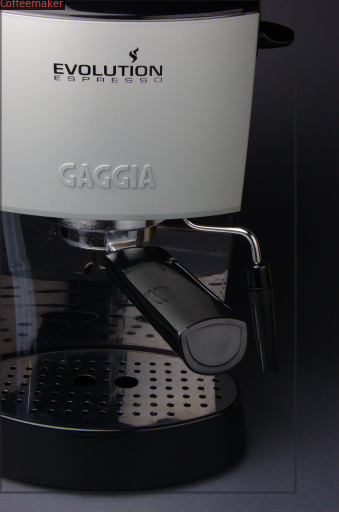

In [0]:
for d in random.sample(val_img_dicts, 1):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coffee_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.

**Note:** Changed to [faster_rcnn_R_50_FPN_1x](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml) from https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

In [0]:
cfg.SOLVER

CfgNode({'LR_SCHEDULER_NAME': 'WarmupMultiStepLR', 'MAX_ITER': 300, 'BASE_LR': 0.00025, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 0.0001, 'WEIGHT_DECAY_NORM': 0.0, 'GAMMA': 0.1, 'STEPS': (60000, 80000), 'WARMUP_FACTOR': 0.001, 'WARMUP_ITERS': 1000, 'WARMUP_METHOD': 'linear', 'CHECKPOINT_PERIOD': 5000, 'IMS_PER_BATCH': 2, 'BIAS_LR_FACTOR': 1.0, 'WEIGHT_DECAY_BIAS': 0.0001})

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("coffeemaker-train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (coffeemaker)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[03/02 06:19:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:23, 7.20MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


In [0]:
trainer.train()

[03/02 06:23:50 d2.engine.train_loop]: Starting training from iteration 0
[03/02 06:24:01 d2.utils.events]:  eta: 0:02:32  iter: 19  total_loss: 1.116  loss_cls: 0.642  loss_box_reg: 0.430  loss_rpn_cls: 0.023  loss_rpn_loc: 0.012  time: 0.5430  data_time: 0.0228  lr: 0.000005  max_mem: 2679M
[03/02 06:24:11 d2.utils.events]:  eta: 0:02:19  iter: 39  total_loss: 1.138  loss_cls: 0.625  loss_box_reg: 0.500  loss_rpn_cls: 0.025  loss_rpn_loc: 0.009  time: 0.5360  data_time: 0.0065  lr: 0.000010  max_mem: 2803M
[03/02 06:24:22 d2.utils.events]:  eta: 0:02:09  iter: 59  total_loss: 1.045  loss_cls: 0.565  loss_box_reg: 0.450  loss_rpn_cls: 0.017  loss_rpn_loc: 0.010  time: 0.5397  data_time: 0.0053  lr: 0.000015  max_mem: 2891M
[03/02 06:24:33 d2.utils.events]:  eta: 0:01:58  iter: 79  total_loss: 0.954  loss_cls: 0.482  loss_box_reg: 0.463  loss_rpn_cls: 0.016  loss_rpn_loc: 0.014  time: 0.5382  data_time: 0.0052  lr: 0.000020  max_mem: 2891M
[03/02 06:24:43 d2.utils.events]:  eta: 0:01:4

In [0]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("coffeemaker-validation", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [0]:
val_img_dicts[0]

{'annotations': [{'bbox': [184.83754, 9.241878, 800.34656, 1024.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}],
 'file_name': '/content/drive/My Drive/Airbnb/coffeemaker-validation/aa9b35d1bee25627.jpg',
 'height': 1024,
 'image_id': 0,
 'width': 1024}

In [0]:
predictor(cv2.imread("/content/drive/My Drive/Airbnb/coffeemaker-validation/aa9b35d1bee25627.jpg"))

{'instances': Instances(num_instances=0, image_height=1024, image_width=1024, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}

{'instances': Instances(num_instances=1, image_height=1024, image_width=768, fields=[pred_boxes: Boxes(tensor([[132.2222,   0.0000, 721.0258, 830.7531]], device='cuda:0')), scores: tensor([0.7047], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


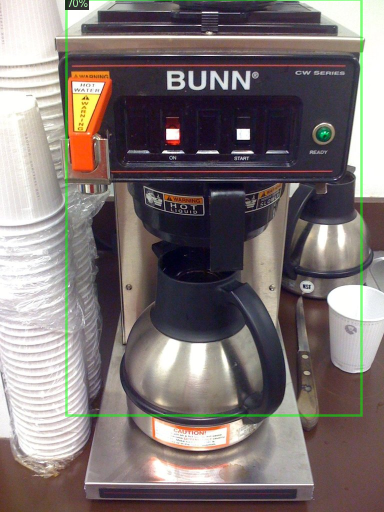

In [0]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(val_img_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=coffee_metadata, 
                   scale=0.5 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("coffeemaker-validation", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "coffeemaker-validation")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [03/02 06:28:32 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'coffeemaker-validation'. Trying to convert it to COCO format ...
[03/02 06:28:32 d2.data.datasets.coco]: Converting dataset annotations in 'coffeemaker-validation' to COCO format ...)
Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    21
Name: ClassName, dtype: int64
[03/02 06:28:33 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/02 06:28:33 d2.data.datasets.coco]: Conversion finished, num images: 20, num annotations: 21
[03/02 06:28:33 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/coffeemaker-validation_coco_format.json
Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    21
Name: ClassName, dtype: int64
[03/02 06:28:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffee

OrderedDict([('bbox',
              {'AP': 46.294068564818126,
               'AP50': 84.63833480122204,
               'AP75': 43.8896475854482,
               'APl': 46.294798726329844,
               'APm': nan,
               'APs': nan})])